In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [2]:
wiki = open('wiki_data.txt', encoding='UTF-8').read().split('\n')

In [ ]:
# Задание 1

In [3]:
#предобработка 
import re
import nltk
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    # лемматизация с NLTK
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [4]:
preprocessed_wiki = [preprocess(line) for line in wiki]

In [5]:
#посчитать количество упоминаний, чтобы отсеять самые редкие
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [6]:
len(vocab)

443187

In [7]:
#возьмем только те, что встретились больше 30 раз
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [8]:
len(filtered_vocab)

17032

In [9]:
#создадим для этого специальный словарь с индексами
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
#Заменяем слова на индексы
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [12]:
# skip gram
X = []
y = []

# увеличиваем размер окна
window = 7
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        context = sent[max(0, i-window):i] + sent[i+1:i+window]  # context (слова до и после целевого)

        for context_word in context:
            X.append(word)
            y.append(context_word)

In [13]:
X[1], y[1]

(14242, 5780)

In [14]:
len(X), len(y)

(2538402, 2538402)

In [15]:
#тестироваться на отложенной выборке
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [16]:
#Создаем нейронную сеть
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=len(word2id), 
                                    input_length=1, 
                                    output_dim=200))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(len(word2id), 
                                activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy')

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 200)            3406600   
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 17033)             3423633   
                                                                 
Total params: 6830233 (26.06 MB)
Trainable params: 6830233 (26.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [18]:
# обучение
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=4)

Epoch 1/4

2412/2412 [==============================] - 425s 176ms/step - loss: 7.7264 - val_loss: 7.4624
Epoch 2/4
2412/2412 [==============================] - 451s 187ms/step - loss: 7.3298 - val_loss: 7.2825
Epoch 3/4
2412/2412 [==============================] - 411s 170ms/step - loss: 7.1212 - val_loss: 7.1580
Epoch 4/4
2412/2412 [==============================] - 439s 182ms/step - loss: 6.9349 - val_loss: 7.0795


dict_keys(['loss', 'val_loss'])


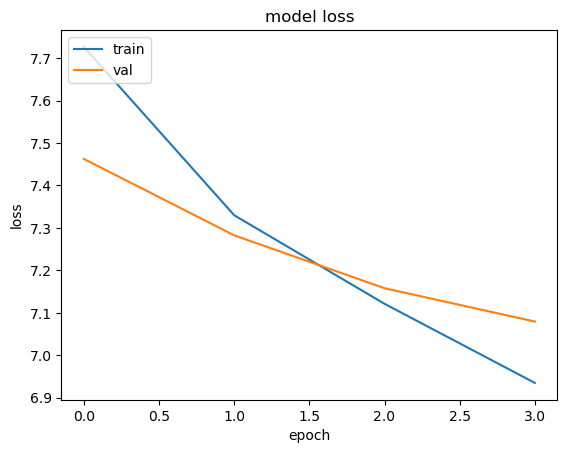

In [19]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
model.layers

In [21]:
# веса embedding слоя
model.layers[0].get_weights()[0].shape

(17033, 200)

In [22]:
# веса полносвязного слоя
model.layers[2].get_weights()[0].shape

(200, 17033)

In [23]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T

In [24]:
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [25]:
embeddings.shape

(17033, 200)

In [26]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [27]:
most_similar('древний', embeddings)

['древний',
 'мрамора',
 'средних',
 'заболевания',
 'мыши',
 'ареала',
 'гитар',
 'ель',
 'меди',
 'низкой']

In [28]:
most_similar('гражданин', embeddings)

['гражданин',
 'татарстан',
 'юлий',
 'литовский',
 'публицист',
 'математик',
 'инфекции',
 'грузинской',
 'кинематографистов',
 'санкт-петербургского']

In [29]:
#cbow (лучше всего сработало)
X = []
y = []

window = 7
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]
        
        X.append(context)
        y.append(word)

In [30]:
# оригинальные контексты
X[:10]

[[269, 5780, 10101, 4350, 4069, 14323],
 [14242, 5780, 10101, 4350, 4069, 14323, 8772],
 [14242, 269, 10101, 4350, 4069, 14323, 8772, 3826],
 [14242, 269, 5780, 4350, 4069, 14323, 8772, 3826, 4350],
 [14242, 269, 5780, 10101, 4069, 14323, 8772, 3826, 4350, 3405],
 [14242, 269, 5780, 10101, 4350, 14323, 8772, 3826, 4350, 3405, 44],
 [14242, 269, 5780, 10101, 4350, 4069, 8772, 3826, 4350, 3405, 44, 10101],
 [14242,
  269,
  5780,
  10101,
  4350,
  4069,
  14323,
  3826,
  4350,
  3405,
  44,
  10101,
  10916],
 [269,
  5780,
  10101,
  4350,
  4069,
  14323,
  8772,
  4350,
  3405,
  44,
  10101,
  10916,
  4350],
 [5780,
  10101,
  4350,
  4069,
  14323,
  8772,
  3826,
  3405,
  44,
  10101,
  10916,
  4350,
  11639]]

In [31]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)

In [32]:
# контексты после паддинга
X

array([[  269,  5780, 10101, ...,     0,     0,     0],
       [14242,  5780, 10101, ...,     0,     0,     0],
       [14242,   269, 10101, ...,  3826,     0,     0],
       ...,
       [14472, 10866,  7605, ..., 13442, 13014, 15713],
       [10866,  7605, 14611, ..., 13014, 15713,     0],
       [ 7605, 14611,  4350, ..., 15713,     0,     0]])

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=10,
                                    output_dim=200))

model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1)))

model.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy')

In [35]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 200)           3406600   
                                                                 
 lambda (Lambda)             (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 17033)             3423633   
                                                                 
Total params: 6830233 (26.06 MB)
Trainable params: 6830233 (26.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [36]:
# обучение
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=4)

Epoch 1/4
1730/1730 [==============================] - 329s 190ms/step - loss: 6.9222 - val_loss: 6.2804
Epoch 2/4
1730/1730 [==============================] - 324s 187ms/step - loss: 5.8780 - val_loss: 5.8705
Epoch 3/4
1730/1730 [==============================] - 325s 188ms/step - loss: 5.3800 - val_loss: 5.7096
Epoch 4/4
1730/1730 [==============================] - 333s 192ms/step - loss: 5.0179 - val_loss: 5.6535


dict_keys(['loss', 'val_loss'])


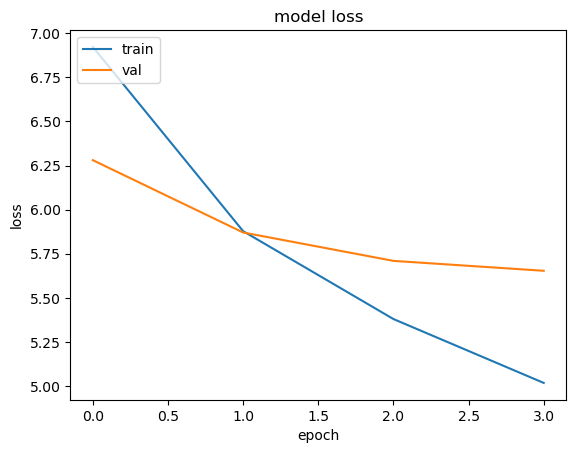

In [37]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
# веса embedding слоя
model.layers[0].get_weights()[0].shape

(17033, 200)

In [39]:
# веса полносвязного слоя
model.layers[2].get_weights()[0].shape

(200, 17033)

In [40]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [41]:
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [42]:
embeddings.shape

(17033, 200)

In [43]:
most_similar('древний', embeddings)

['древний',
 'крупный',
 'распространённый',
 'превратился',
 'самый',
 'египет',
 'инструмент',
 'расположенный',
 'кафедральный',
 'стеной']

In [44]:
most_similar('гражданин', embeddings)

['гражданин',
 'почётный',
 'почетный',
 'юрист',
 'почётного',
 'заслуженный',
 'лауреат',
 'филологических',
 'мэр',
 'гражданина']

In [ ]:
# негативное семплирование

In [45]:
vocab_size = len(id2word)

In [46]:
# skip gram
def gen_batches_sg(sentences, window = 7, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [47]:
# cbow 
def gen_batches_cbow(sentences, window = 7, batch_size=1000):
    
    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [48]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
# обучение
model.fit(gen_batches_sg(sentences[:19000], window=7),
          validation_data=gen_batches_sg(sentences[19000:],  window=7),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2



5000/5000 [==============================] - 347s 69ms/step - loss: 0.4849 - accuracy: 0.7706 - val_loss: 0.5075 - val_accuracy: 0.7644
Epoch 2/2
5000/5000 [==============================] - 349s 70ms/step - loss: 0.4540 - accuracy: 0.7947 - val_loss: 0.4315 - val_accuracy: 0.8074


In [50]:
embeddings = model.layers[2].get_weights()[0]

In [51]:
most_similar('древний', embeddings) #плоховато

['древний',
 'восточный',
 'братской',
 'поселении',
 'берёт',
 'эскадрона',
 'преобразован',
 '1545',
 'общая',
 'свое']

In [52]:
most_similar('гражданин', embeddings)

['гражданин',
 'политехнического',
 'утверждено',
 'грузинский',
 '1785',
 'поселке',
 'швейцарский',
 'новосибирск',
 'введен',
 'выросла']

In [ ]:
# Задание 2

In [53]:
import gensim

In [54]:
?gensim.models.Word2Vec

In [55]:
gensim.__version__

'4.3.2'

In [56]:
wiki = open('wiki_data.txt', encoding='UTF-8').read().split('\n')

In [57]:
#предобработка 
import re
import nltk
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    # лемматизация с NLTK
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [58]:
texts = [preprocess(text) for text in wiki]

In [59]:
%%time
w2v = gensim.models.Word2Vec(texts, )

CPU times: total: 38.5 s
Wall time: 14.8 s


In [60]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=400, 
                             min_count=40, 
                             max_vocab_size=9000,
                             window=7,
                             epochs=6,
                             sample=3e-5,
                             ns_exponent=0.79,
                             sg=1,
                             cbow_mean=0,
                             negative=13,
                            )

CPU times: total: 41.4 s
Wall time: 14.6 s


In [61]:
# не нашлось
w2v.wv.most_similar('древний')

KeyError: "Key 'древний' not present in vocabulary"

In [62]:
%%time
ft = gensim.models.FastText(texts,
                            vector_size=400, 
                             min_count=40, 
                             max_vocab_size=9000,
                             window=7,
                             epochs=6,
                             sample=3e-5,
                             ns_exponent=0.79,
                             sg=1,
                             cbow_mean=0,
                             negative=13,
                            )

CPU times: total: 1min 12s
Wall time: 27 s


In [63]:
ft.wv.most_similar('древний')

[('деревни', 0.7490487694740295),
 ('шесть', 0.6464866995811462),
 ('деревня', 0.628713071346283),
 ('здесь', 0.6284742951393127),
 ('находились', 0.6277707815170288),
 ('ещё', 0.6168389916419983),
 ('жители', 0.6058354377746582),
 ('отечественной', 0.6042746305465698),
 ('них', 0.6042373776435852),
 ('и', 0.6007201075553894)]

In [64]:
ft.wv.most_similar('гражданин')

[('гражданской', 0.9448617696762085),
 ('войны', 0.7367572784423828),
 ('войне', 0.7343419790267944),
 ('службы', 0.7198446989059448),
 ('советской', 0.7023519277572632),
 ('революции', 0.6977463960647583),
 ('служил', 0.696311891078949),
 ('отечественной', 0.6961001753807068),
 ('армии', 0.6893061399459839),
 ('неоднократно', 0.6847240328788757)]

In [ ]:
# Задание 3

In [65]:
data = pd.read_csv('labeled.csv')

In [66]:
data['norm_text'] = data.comment.apply(preprocess)

In [67]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

7232

In [68]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [69]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [70]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [ ]:
# не получилось скачать с сайта https://rusvectores.org/ru/models/